**Installing dependencies and Deepforest** **library**

In [2]:
#install the package, on colab make sure to upgrade existing packages. This is not needed in a clean env.
! pip install --upgrade deepforest albumentations pyyaml

     |████████████████████████████████| 20.0 MB 6.8 MB/s 
     |████████████████████████████████| 98 kB 5.6 MB/s 
     |████████████████████████████████| 636 kB 61.8 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 28.5 MB 49 kB/s 
     |████████████████████████████████| 923 kB 67.8 MB/s 
     |████████████████████████████████| 29.6 MB 45 kB/s 
     |████████████████████████████████| 994 kB 53.0 MB/s 
     |████████████████████████████████| 994 kB 70.2 MB/s 
     |████████████████████████████████| 37.1 MB 52 kB/s 
     |████████████████████████████████| 6.3 MB 42.0 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 
     |████████████████████████████████| 829 kB 41.9 MB/s 
     |████████████████████████████████| 282 kB 47.9 MB/s 
     |████████████████████████████████| 119 kB 47.2 MB/s 
     |████████████████████████████████| 1.3 MB 63.3 MB/s 
     |████████████████████████████████| 142 kB 58.5 MB/s 
     |██████████████

**Importing Dependencies from the package**

In [3]:
#load the modules
import os
import time
import numpy as np
from deepforest import main 
from deepforest import get_data
from deepforest import utilities
from deepforest import preprocess

**Getting the training data in the module**

In [4]:
#convert hand annotations from xml into retinanet format
#The get_data function is only needed when fetching sample package data
YELL_xml = get_data("2019_YELL_2_528000_4978000_image_crop2.xml")
annotation = utilities.xml_to_annotations(YELL_xml)
annotation.head()

,image_path,xmin,ymin,xmax,ymax,label
0,2019_YELL_2_528000_4978000_image_crop2.png,681,369,699,386,Tree
1,2019_YELL_2_528000_4978000_image_crop2.png,980,59,998,79,Tree
2,2019_YELL_2_528000_4978000_image_crop2.png,953,135,964,150,Tree
3,2019_YELL_2_528000_4978000_image_crop2.png,969,183,995,208,Tree
4,2019_YELL_2_528000_4978000_image_crop2.png,742,623,751,635,Tree


**Getting the annotation file from the imported XML file in csv format**

In [5]:
#load the image file corresponding to the annotaion file
YELL_train = get_data("2019_YELL_2_528000_4978000_image_crop2.png")
image_path = os.path.dirname(YELL_train)
#Write converted dataframe to file. Saved alongside the images
annotation.to_csv(os.path.join(image_path,"train_example.csv"), index=False)

**Specifying annotation path and preprocess for training**

In [6]:
#Find annotation path
annotation_path = os.path.join(image_path,"train_example.csv")
#crop images will save in a newly created directory
#os.mkdir(os.getcwd(),'train_data_folder')
crop_dir = os.path.join(os.getcwd(),'train_data_folder')
train_annotations= preprocess.split_raster(path_to_raster=YELL_train,
                                 annotations_file=annotation_path,
                                 base_dir=crop_dir,
                                 patch_size=400,
                                 patch_overlap=0.05)

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/loca

**Spliting the image dataset into 75:25 for training and testing the model**

In [7]:
#Split image crops into training and test. Normally these would be different tiles! Just as an example.
image_paths = train_annotations.image_path.unique()
#split 25% validation annotation
valid_paths = np.random.choice(image_paths, int(len(image_paths)*0.25) )
valid_annotations = train_annotations.loc[train_annotations.image_path.isin(valid_paths)]
train_annotations = train_annotations.loc[~train_annotations.image_path.isin(valid_paths)]

**Viewing the Ground truth of the image by annotations**

In [8]:
#View output
train_annotations.head()
print("There are {} training crown annotations".format(train_annotations.shape[0]))
print("There are {} test crown annotations".format(valid_annotations.shape[0]))

#save to file and create the file dir
annotations_file= os.path.join(crop_dir,"train.csv")
validation_file= os.path.join(crop_dir,"valid.csv")
#Write window annotations file without a header row, same location as the "base_dir" above.
train_annotations.to_csv(annotations_file,index=False)
valid_annotations.to_csv(validation_file,index=False)

There are 590 training crown annotations
There are 184 test crown annotations


**Training the model by configuring cofig files**

In [9]:
#initial the model and change the corresponding config file
m = main.deepforest()
m.config["train"]["csv_file"] = annotations_file
m.config["train"]["root_dir"] = os.path.dirname(annotations_file)
#Since this is a demo example and we aren't training for long, only show the higher quality boxes
m.config["score_thresh"] = 0.4
m.config["train"]['epochs'] = 2
m.config["validation"]["csv_file"] = validation_file
m.config["validation"]["root_dir"] = os.path.dirname(validation_file)
#create a pytorch lighting trainer used to training 
m.create_trainer()
#load the lastest release model 
m.use_release()

Reading config file: /usr/local/lib/python3.7/dist-packages/deepforest/data/deepforest_config.yml


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


NEON.pt: 129MB [00:03, 41.4MB/s]                           

Model was downloaded and saved to /usr/local/lib/python3.7/dist-packages/deepforest/data/NEON.pt
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


**Start the training and measuring the time taken to train for 2 epochs**

In [10]:
start_time = time.time()
m.trainer.fit(m)
print(f"--- Training on CPU: {(time.time() - start_time):.2f} seconds ---")


  | Name  | Type      | Params
------------------------------------
0 | model | RetinaNet | 32.1 M
------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

--- Training on CPU: 1070.03 seconds ---


**Saving the trained model and prediction result in the save_dir**

In [11]:
#create a directory to save the predict image
save_dir = os.path.join(os.getcwd(),'pred_result')
try:
  os.mkdir(save_dir)
except FileExistsError:
  pass
results = m.evaluate(annotations_file, os.path.dirname(annotations_file), iou_threshold = 0.4, savedir = save_dir)

In [20]:
save_dir

'/content/pred_result'

**Testing the trained model by specifying unknown forest image to count trees**

In [25]:
raster_path = get_data("OSBS_029.tif")
# Window size of 300px with an overlap of 25% among windows for this small tile.
predicted_raster = m.predict_tile(raster_path, return_plot = True, patch_size=300,patch_overlap=0.25, color=(0, 165, 255), thickness=3)

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/deepforest/predict.py:34: UserWarning: Image type is {}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')
  warnings.warn("Image type is {}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')")
100%|██████████| 4/4 [00:20<00:00,  5.09s/it]

110 predictions in overlapping windows, applying non-max supression
53 predictions kept after non-max suppression


**Viewing the plot to see the predictions and overlaps**

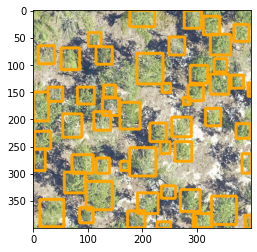

In [26]:
plt.imshow(predicted_raster[:,:,::-1])

In [21]:
raster_path

'/usr/local/lib/python3.7/dist-packages/deepforest/data/OSBS_029.tif'

In [23]:
len(predicted_raster)

400

In [19]:
os.listdir(save_dir)

['2019_YELL_2_528000_4978000_image_crop2_30.png',
 '2019_YELL_2_528000_4978000_image_crop2_28.png',
 '2019_YELL_2_528000_4978000_image_crop2_23.png',
 '2019_YELL_2_528000_4978000_image_crop2_29.png',
 '2019_YELL_2_528000_4978000_image_crop2_5.png',
 '2019_YELL_2_528000_4978000_image_crop2_26.png',
 '2019_YELL_2_528000_4978000_image_crop2_33.png',
 '2019_YELL_2_528000_4978000_image_crop2_37.png',
 '2019_YELL_2_528000_4978000_image_crop2_27.png',
 '2019_YELL_2_528000_4978000_image_crop2_17.png',
 '2019_YELL_2_528000_4978000_image_crop2_20.png',
 '2019_YELL_2_528000_4978000_image_crop2_6.png',
 '2019_YELL_2_528000_4978000_image_crop2_8.png',
 '2019_YELL_2_528000_4978000_image_crop2_40.png',
 '2019_YELL_2_528000_4978000_image_crop2_11.png',
 '2019_YELL_2_528000_4978000_image_crop2_36.png',
 '2019_YELL_2_528000_4978000_image_crop2_13.png',
 '2019_YELL_2_528000_4978000_image_crop2_7.png',
 '2019_YELL_2_528000_4978000_image_crop2_38.png',
 '2019_YELL_2_528000_4978000_image_crop2_24.png',
 '20

**Viewing the prediction result of Testing Dataset**

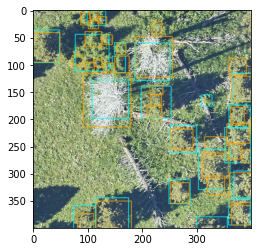

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/pred_result/2019_YELL_2_528000_4978000_image_crop2_32.png')
imgplot = plt.imshow(img)
plt.show()

In [28]:
results

{'box_precision': 0.8588920451440433,
 'box_recall': 0.7156887346252409,
 'class_recall':    label  recall  precision  size
 0      0     1.0        1.0   479,
 'results':    prediction_id  ...  match
 9              9  ...  False
 3              3  ...   True
 10            10  ...   True
 11            11  ...   True
 0           None  ...  False
 ..           ...  ...    ...
 0           None  ...  False
 3              3  ...   True
 2              2  ...   True
 4              4  ...   True
 1              1  ...   True
 
 [590 rows x 8 columns]}

In [29]:
results['results']

,prediction_id,truth_id,IoU,score,predicted_label,true_label,image_path,match
9,9,0,0.287984,0.532279,Tree,Tree,2019_YELL_2_528000_4978000_image_crop2_10.png,False
3,3,1,0.723513,0.721777,Tree,Tree,2019_YELL_2_528000_4978000_image_crop2_10.png,True
10,10,2,0.757569,0.532127,Tree,Tree,2019_YELL_2_528000_4978000_image_crop2_10.png,True
11,11,3,0.739163,0.530556,Tree,Tree,2019_YELL_2_528000_4978000_image_crop2_10.png,True
0,None,4,0.000000,NaN,NaN,Tree,2019_YELL_2_528000_4978000_image_crop2_10.png,False
...,...,...,...,...,...,...,...,...
0,None,5,0.000000,NaN,NaN,Tree,2019_YELL_2_528000_4978000_image_crop2_9.png,False
3,3,6,0.740053,0.721398,Tree,Tree,2019_YELL_2_528000_4978000_image_crop2_9.png,True
2,2,7,0.682834,0.761684,Tree,Tree,2019_YELL_2_528000_4978000_image_crop2_9.png,True
4,4,8,0.739105,0.694455,Tree,Tree,2019_YELL_2_528000_4978000_image_crop2_9.png,True


In [31]:
results['box_precision']

0.8588920451440433